# Analysing GeneralHospital SQL Server Database

In [7]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import geopandas
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup as bs
import requests

In [8]:
pd.options.display.max_columns=100
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [9]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DESKTOP-T040CLA\SQLEXPRESS;'
                      'Database=GeneralHospital;'
                      'Trusted_Connection=yes;')

In [10]:
%%time
cities=geopandas.read_file(r"C:\Users\berid\python\geopandas\tl_2022_us_cities\tl_2022_us_county.shp")
zips=geopandas.read_file(r"C:\Users\berid\python\geopandas\tl_2019_us_zcta510_zipcodes\tl_2019_us_zcta510.shp")
states=geopandas.read_file(r"C:\Users\berid\python\geopandas\s_22mr22_states\s_22mr22.shp")

#scrape USA cities data
cities_data=pd.DataFrame()
for i in range(1,13):
    url=f'https://www.latlong.net/category/cities-236-15-{i}.html'
    df=pd.read_html(url)[0]
    cities_data=pd.concat([cities_data,df],ignore_index=True)
#clean data
cities_data['State']=cities_data['Place Name'].str.split(',').str[1].str.strip()
cities_data['City']=cities_data['Place Name'].str.split(',').str[0].str.strip()
cities_data=cities_data[cities_data['State']=='PA']

CPU times: total: 2min 23s
Wall time: 2min 46s


In [11]:
cities=cities[cities['STATEFP']=="42"]

In [12]:
cities['long']=cities['geometry'].centroid.x
cities['lat']=cities['geometry'].centroid.y

In [13]:
hospitals=pd.read_sql('SELECT * FROM Hospitals',conn)
patients=pd.read_sql('SELECT * FROM Patients',conn)
encounters=pd.read_sql('SELECT * FROM Encounters',conn)
vitals=pd.read_sql('SELECT * FROM Vitals',conn)
departments=pd.read_sql('SELECT * FROM Departments',conn)
accounts=pd.read_sql('SELECT * FROM Accounts',conn)
sc=pd.read_sql('SELECT * FROM SurgicalCosts',conn)

In [14]:
patients,hospitals,encounters,vitals,departments,accounts,sc

(     Master Patient ID Patient Address Number Patient Address Street  \
 0               102830                   1509            Woodland Rd   
 1               102831                    795        S Westbourne Rd   
 2               102832                     56           S Garden Cir   
 3               102833                    787              Edward Ln   
 4               102834                   1009         Windy Knoll Rd   
 ...                ...                    ...                    ...   
 7091            107305                   1800              Walnut St   
 7092            107306                   2500             Mifflin St   
 7093            107307                   2150              S 24th St   
 7094            107308                   1749              S 26th St   
 7095            107309                    249              Morris St   
 
      Patient Address Full  Patient City Patient Zip Code Patient County  \
 0        1509 Woodland Rd  West Chester      

In [15]:
patients['Patient Longitude']=patients['Patient Longitude'].astype(float)
patients['Patient Latitude']=patients['Patient Latitude'].astype(float)

hospitals['Hospital Longitude']=hospitals['Hospital Longitude'].astype(float)
hospitals['Hospital Latitude']=hospitals['Hospital Latitude'].astype(float)

In [16]:
zips=zips[zips['GEOID10'].isin(patients['Patient Zip Code'].unique())]
zips['Area in sqkm']=zips['geometry'].to_crs({'proj':'cea'}).area/10**6 # creating polygon area column

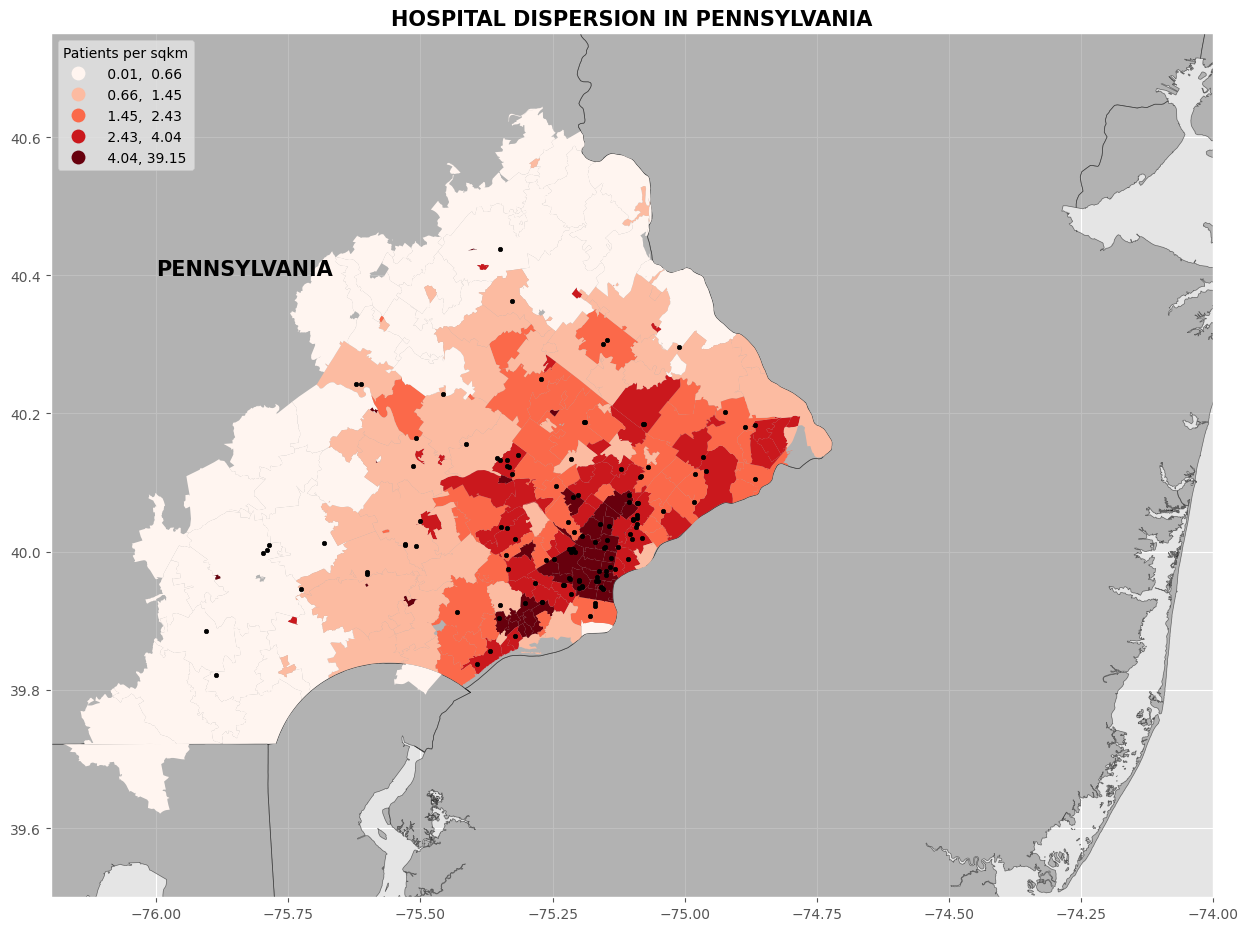

CPU times: total: 12.5 s
Wall time: 15.6 s


In [17]:
%%time
grouped=patients.groupby('Patient Zip Code')['Master Patient ID'].count().reset_index()
grouped=grouped.merge(zips[['GEOID10','geometry','Area in sqkm']],left_on='Patient Zip Code',right_on='GEOID10')
grouped['Patient per sqkm']=grouped['Master Patient ID']/grouped['Area in sqkm']
grouped=geopandas.GeoDataFrame(grouped)

fig,ax=plt.subplots(figsize=(15,15))
states.plot(ax=ax,color='grey',ec='black',alpha=0.5)
grouped.plot(ax=ax,column='Patient per sqkm',scheme='quantiles',cmap='Reds',legend=True,
            legend_kwds={'loc': 'upper left', 'title':'Patients per sqkm'})
ax.scatter(hospitals['Hospital Longitude'],hospitals['Hospital Latitude'],c='k',s=10,label='Hospital')
plt.xlim(-76.2,-74)
plt.ylim(39.5,40.75)
plt.text(-76,40.4,'PENNSYLVANIA',fontweight='bold',size=15)
plt.title('HOSPITAL DISPERSION IN PENNSYLVANIA',fontweight='bold',size=15)
plt.show()

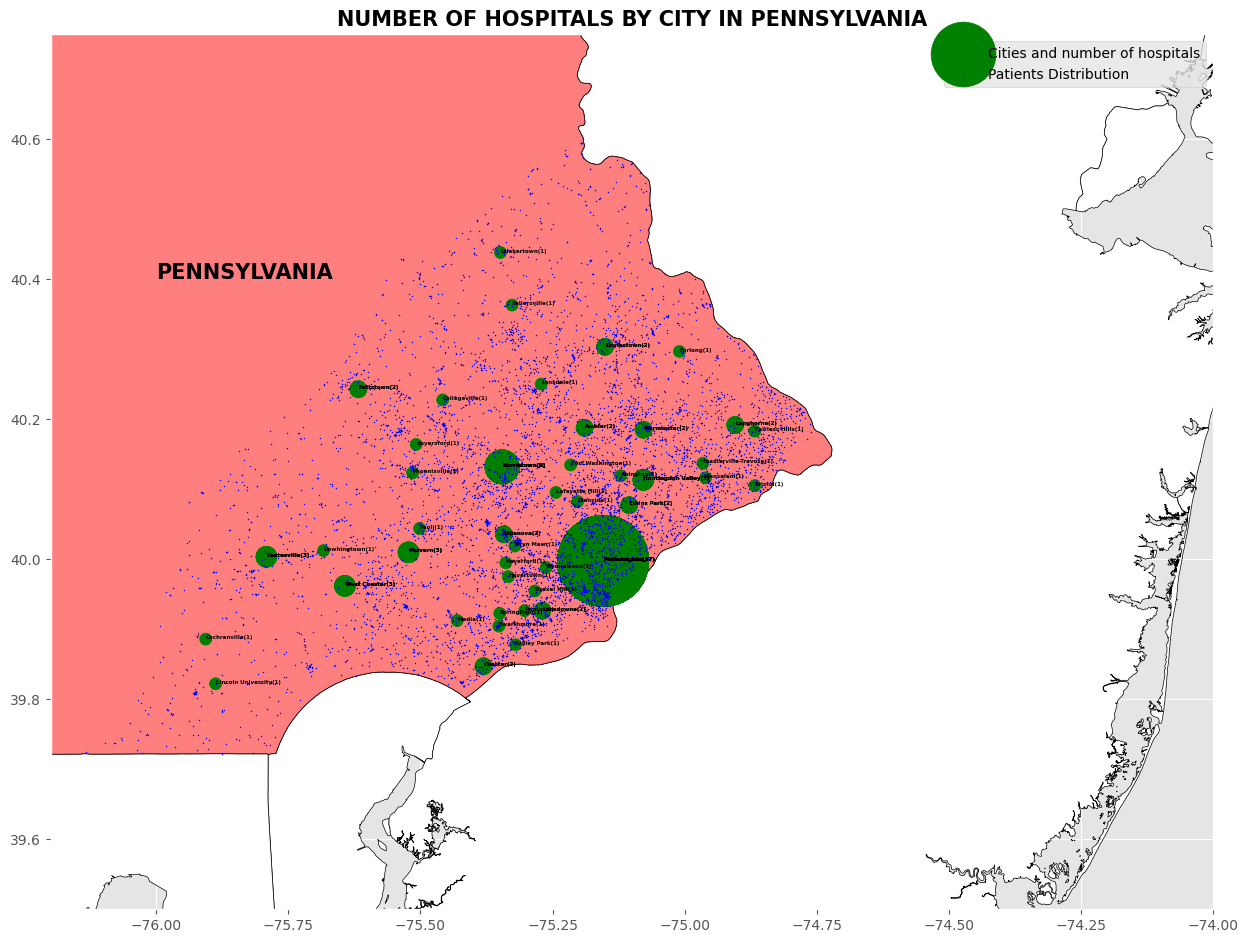

CPU times: total: 11.6 s
Wall time: 12.6 s


In [18]:
%%time
hospitals['Hospital Centroid Longitude']=hospitals.groupby(['Hospital City'])['Hospital Longitude'].transform(lambda x:x.mean())
hospitals['Hospital Centroid Latitude']=hospitals.groupby(['Hospital City'])['Hospital Latitude'].transform(lambda x:x.mean())

grouped=hospitals.groupby('Hospital City')['Hospital ID'].count().reset_index()
grouped=grouped.merge(hospitals[['Hospital City','Hospital Centroid Longitude','Hospital Centroid Latitude']],on='Hospital City')

fig,ax=plt.subplots(figsize=(15,15))
states.plot(ax=ax,color='white',ec='black')
states.query('STATE=="PA"').plot(ax=ax,color='red',ec='black',alpha=0.5)
ax.scatter(grouped['Hospital Centroid Longitude'],grouped['Hospital Centroid Latitude'],c='green',s=grouped['Hospital ID']*75,label='Cities and number of hospitals')
ax.scatter(patients['Patient Longitude'],patients['Patient Latitude'],color='blue',s=0.3,label='Patients Distribution')
plt.xlim(-76.2,-74)
plt.ylim(39.5,40.75)
plt.text(-76,40.4,'PENNSYLVANIA',fontweight='bold',size=15)
plt.title('NUMBER OF HOSPITALS BY CITY IN PENNSYLVANIA',fontweight='bold',size=15)
for i in range(len(grouped)):
    plt.text(grouped['Hospital Centroid Longitude'][i],grouped['Hospital Centroid Latitude'][i],f"{grouped['Hospital City'][i]}({grouped['Hospital ID'][i]})",fontweight='bold',size=4)
plt.legend()
plt.show()

In [28]:
merged=pd.read_sql("""
SELECt [Hospital ID],[Hospital Longitude],[Hospital Latitude],[Master Patient ID],[Patient Longitude],[Patient Latitude]
FROM Hospitals, Patients
""",conn)

merged['Hospital Longitude']=merged['Hospital Longitude'].astype(float)
merged['Hospital Latitude']=merged['Hospital Latitude'].astype(float)
merged['Patient Longitude']=merged['Patient Longitude'].astype(float)
merged['Patient Latitude']=merged['Patient Latitude'].astype(float)

merged['Distance']=merged.apply(lambda x:
((x['Hospital Longitude']-x['Patient Longitude'])**2+(x['Hospital Latitude']-x['Patient Latitude'])**2)**0.5,axis=1)

merged['Distance']=merged['Distance']*111.1

In [29]:
grouped=merged.query('Distance<10').groupby('Hospital ID')['Master Patient ID'].count().reset_index().sort_values('Master Patient ID',ascending=False)
grouped=grouped.head(10)

grouped=grouped.merge(merged[['Hospital ID','Hospital Longitude','Hospital Latitude']],on='Hospital ID')

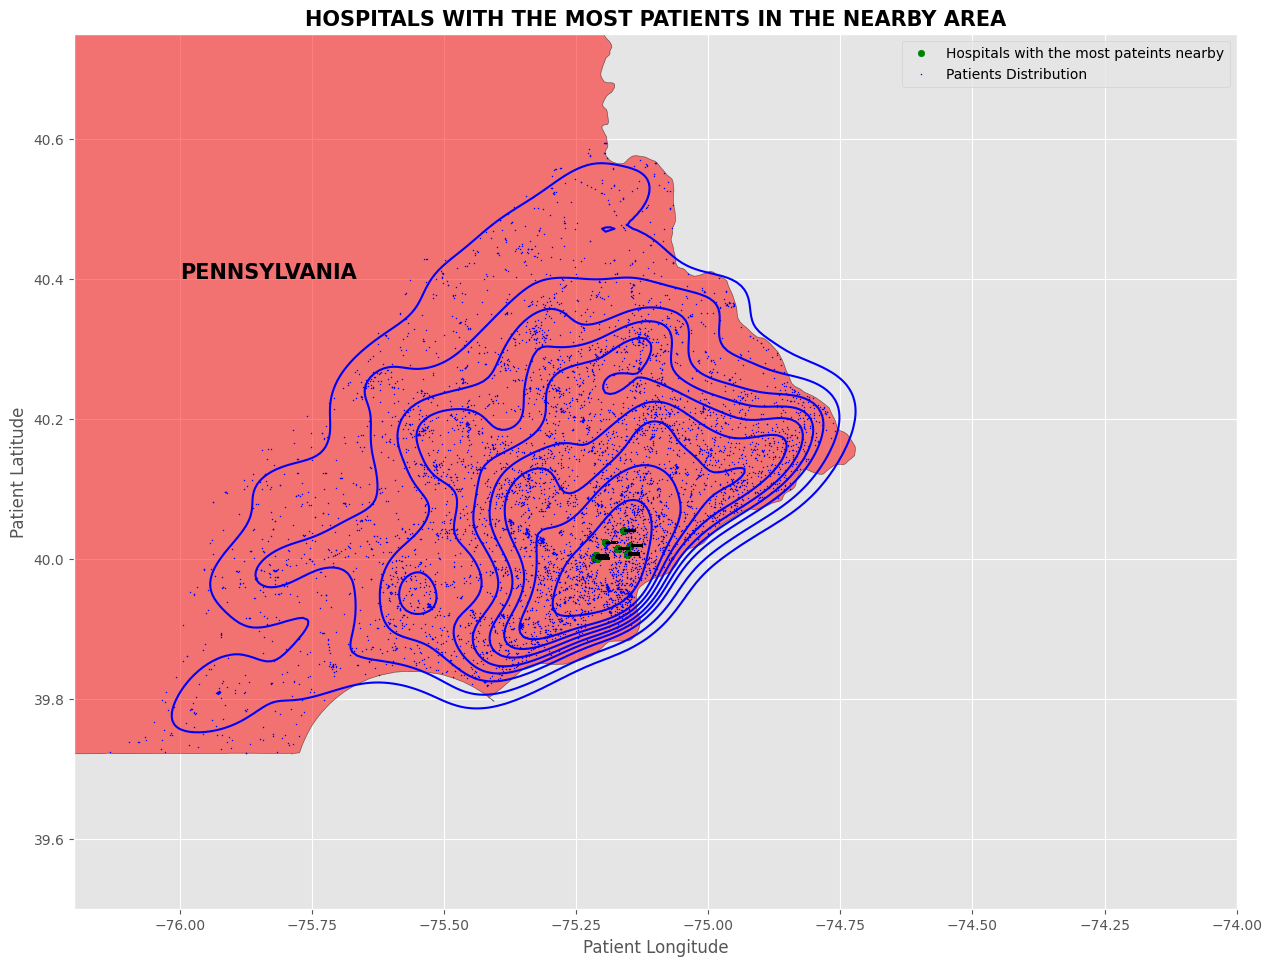

CPU times: total: 3min 47s
Wall time: 3min 58s


In [31]:
%%time
fig,ax=plt.subplots(figsize=(15,15))
#states.plot(ax=ax,color='white',ec='black')
states.query('STATE=="PA"').plot(ax=ax,color='red',ec='black',alpha=0.5)
sns.kdeplot(x=patients['Patient Longitude'],y=patients['Patient Latitude'],color='blue')
ax.scatter(grouped['Hospital Longitude'],grouped['Hospital Latitude'],color='green',s=grouped['Master Patient ID']/50,label='Hospitals with the most pateints nearby')
ax.scatter(patients['Patient Longitude'],patients['Patient Latitude'],color='blue',s=0.3,label='Patients Distribution')
plt.xlim(-76.2,-74)
plt.ylim(39.5,40.75)
plt.text(-76,40.4,'PENNSYLVANIA',fontweight='bold',size=15)
plt.title('HOSPITALS WITH THE MOST PATIENTS IN THE NEARBY AREA',fontweight='bold',size=15)
for i in range(len(grouped)):
    plt.text(grouped['Hospital Longitude'][i],grouped['Hospital Latitude'][i],grouped['Hospital ID'][i],fontweight='bold',size=2)
plt.legend()
plt.show()

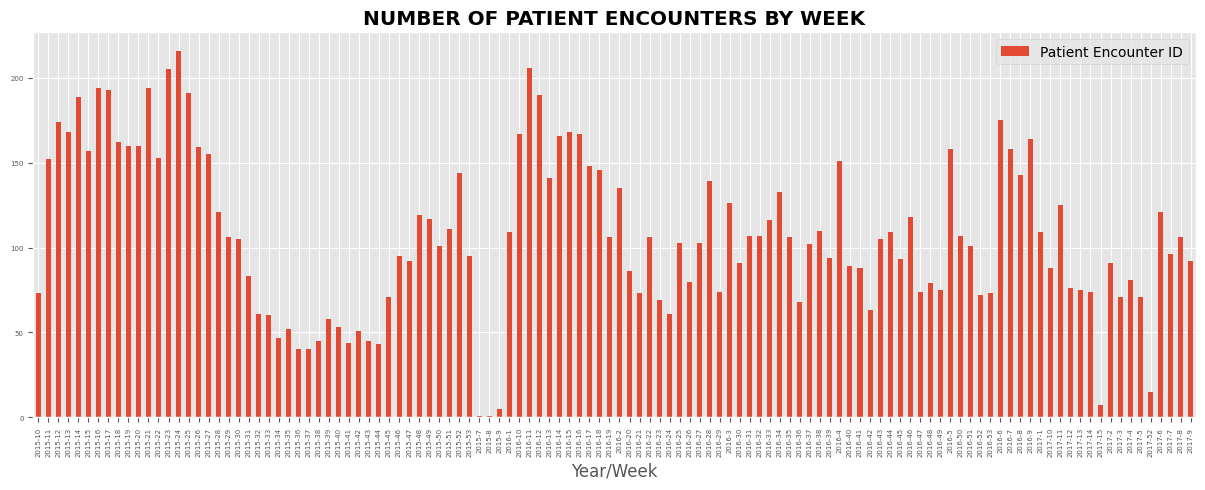

In [32]:
encounters['Patient Admission Datetime']=pd.to_datetime(encounters['Patient Admission Datetime']).dt.normalize()
encounters['Patient Discharge Datetime']=pd.to_datetime(encounters['Patient Discharge Datetime']).dt.normalize()

encounters['Admission Year']=encounters['Patient Admission Datetime'].dt.year.astype(str)
encounters['Admission Week']=encounters['Patient Admission Datetime'].dt.week.astype(str)
encounters['Year/Week']=encounters['Admission Year']+'-'+encounters['Admission Week']
encounters=encounters.drop(columns=['Admission Year','Admission Week'])

grouped=encounters.groupby('Year/Week')['Patient Encounter ID'].count().reset_index()
grouped=grouped.sort_values('Year/Week')

grouped.plot(kind='bar',figsize=(15,5),x='Year/Week',y='Patient Encounter ID',fontsize=5)
plt.title('NUMBER OF PATIENT ENCOUNTERS BY WEEK',fontweight='bold')
plt.show()

encounters.drop(columns='Year/Week',inplace=True)

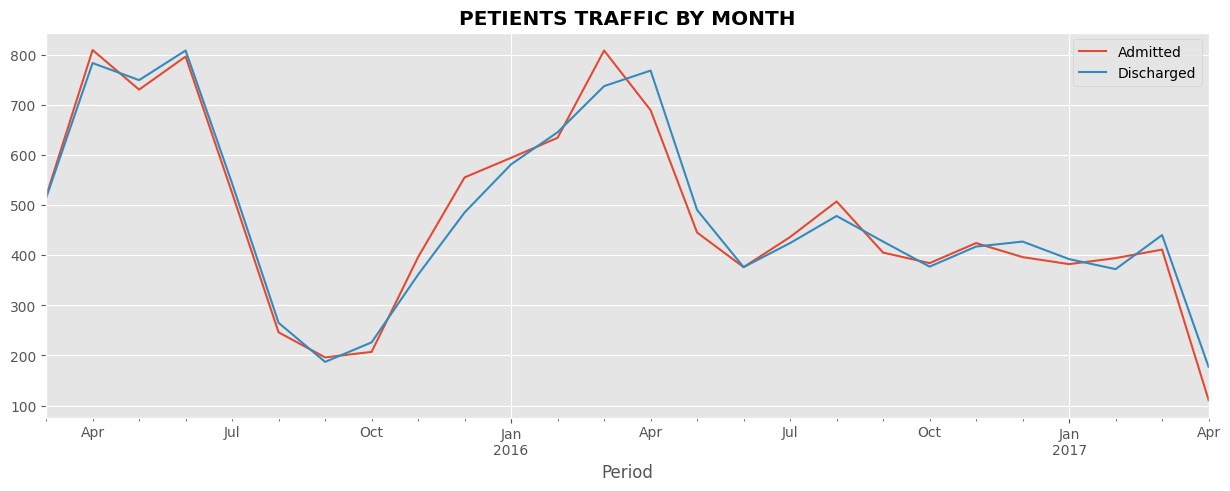

In [33]:
encounters_hospitals=pd.merge(encounters,departments[['Department ID','Hospital ID']],on='Department ID')
encounters_hospitals=encounters_hospitals[['Patient Encounter ID','Patient Admission Datetime','Patient Discharge Datetime','Hospital ID']]

encounters_hospitals['Patient Admission Datetime']=pd.to_datetime(encounters_hospitals['Patient Admission Datetime']).dt.normalize()
encounters_hospitals['Patient Discharge Datetime']=pd.to_datetime(encounters_hospitals['Patient Discharge Datetime']).dt.normalize()

grouped_admission=encounters_hospitals.groupby('Patient Admission Datetime')['Patient Encounter ID'].count().reset_index()
grouped_discharge=encounters_hospitals.groupby('Patient Discharge Datetime')['Patient Encounter ID'].count().reset_index()

merged=grouped_admission.merge(grouped_discharge,left_on='Patient Admission Datetime',right_on='Patient Discharge Datetime')
merged=merged.iloc[:,[0,1,3]]
merged.columns=['Date','Admitted','Discharged']
merged['Period']=merged['Date'].dt.to_period('M')

grouped=merged.groupby('Period')[['Admitted','Discharged']].sum().reset_index()

grouped.plot(kind='line',x='Period',figsize=(15,5))
plt.title('PETIENTS TRAFFIC BY MONTH',fontweight='bold')
plt.show()

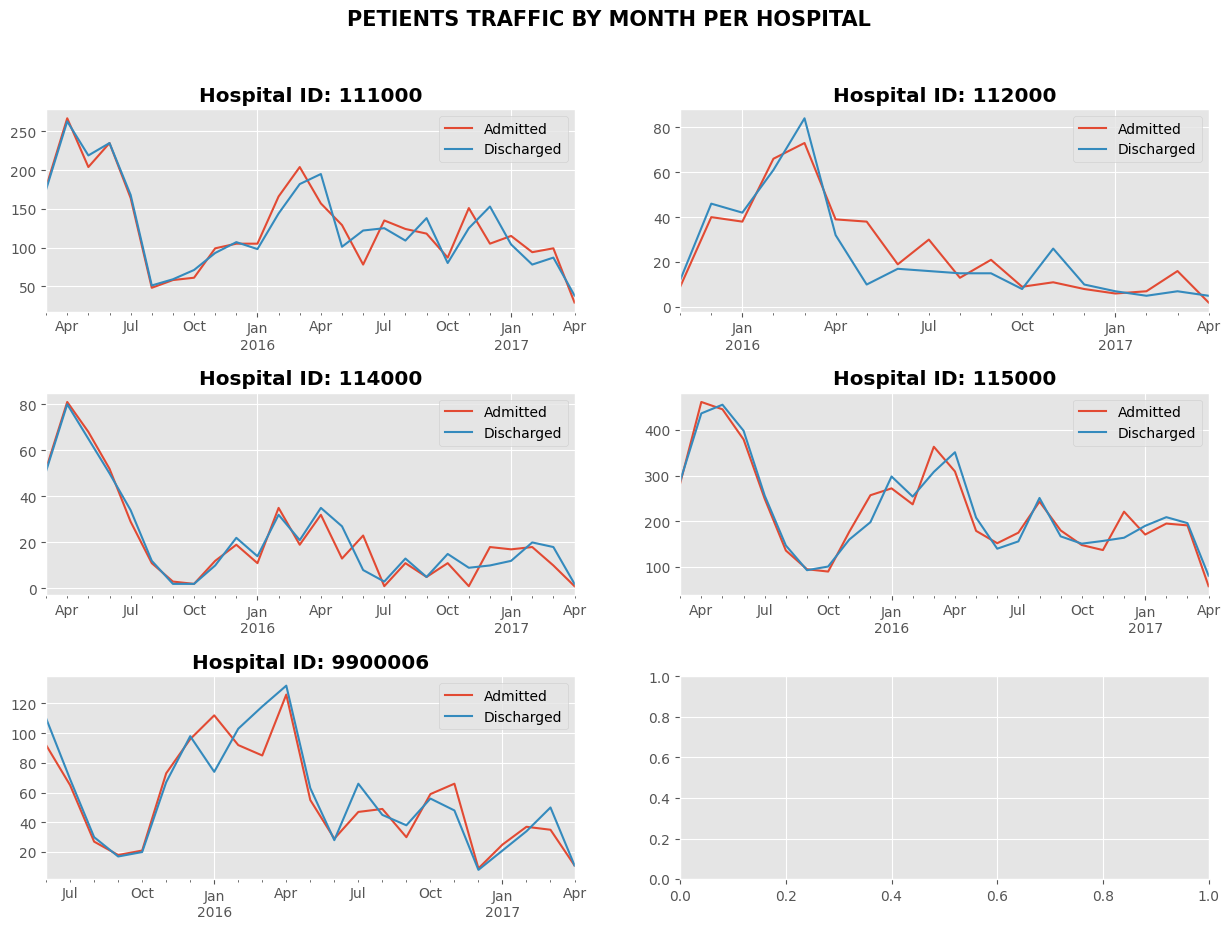

In [34]:
encounters_hospitals=pd.merge(encounters,departments[['Department ID','Hospital ID']],on='Department ID')
encounters_hospitals=encounters_hospitals[['Patient Encounter ID','Patient Admission Datetime','Patient Discharge Datetime','Hospital ID']]

encounters_hospitals['Patient Admission Datetime']=pd.to_datetime(encounters_hospitals['Patient Admission Datetime']).dt.normalize()
encounters_hospitals['Patient Discharge Datetime']=pd.to_datetime(encounters_hospitals['Patient Discharge Datetime']).dt.normalize()

grouped_admission=encounters_hospitals.groupby(['Hospital ID','Patient Admission Datetime'])['Patient Encounter ID'].count().reset_index()
grouped_discharge=encounters_hospitals.groupby(['Hospital ID','Patient Discharge Datetime'])['Patient Encounter ID'].count().reset_index()

merged=grouped_admission.merge(grouped_discharge,left_on=['Hospital ID','Patient Admission Datetime'],right_on=['Hospital ID','Patient Discharge Datetime'])
merged=merged.iloc[:,[0,1,2,4]]
merged.columns=['Hospital ID','Date','Admitted','Discharged']
merged['Period']=merged['Date'].dt.to_period('M')

grouped=merged.groupby(['Hospital ID','Period'])[['Admitted','Discharged']].sum().reset_index()


fig,axes=plt.subplots(3,2,figsize=(15,10))
for hospital,ax in zip(grouped['Hospital ID'].unique(),axes.ravel()):
    grouped.query('`Hospital ID`==@hospital').plot(ax=ax,kind='line',x='Period',xlabel='')
    ax.set_title(f'Hospital ID: {hospital}',fontweight='bold')
plt.suptitle('PETIENTS TRAFFIC BY MONTH PER HOSPITAL',fontweight='bold',size=15)
plt.subplots_adjust(hspace=0.4)
plt.show()

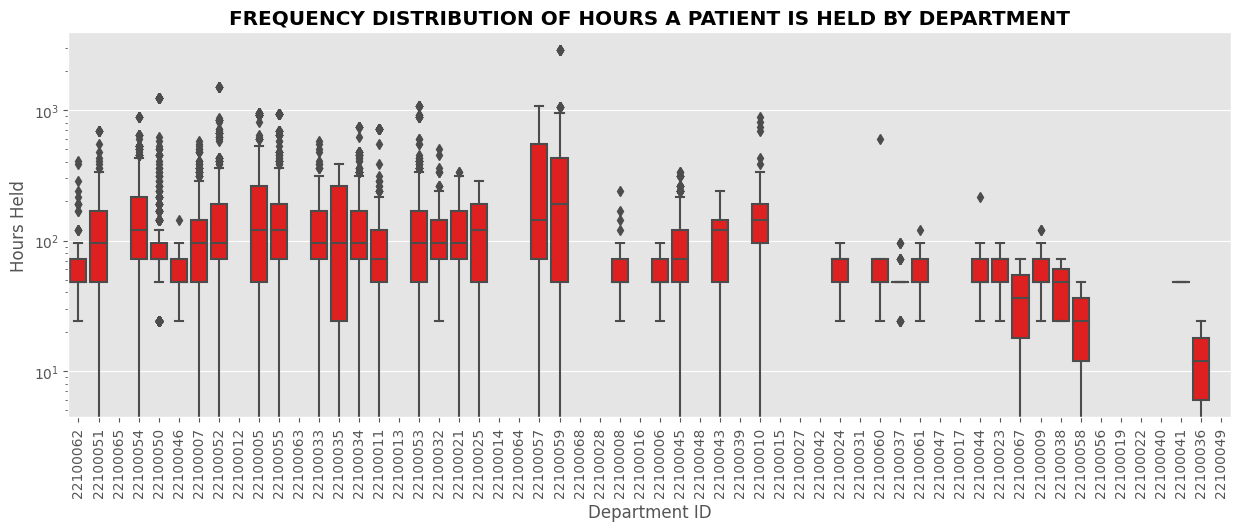

In [35]:
encounters['Patient Admission Datetime']=pd.to_datetime(encounters['Patient Admission Datetime'])
encounters['Patient Discharge Datetime']=pd.to_datetime(encounters['Patient Discharge Datetime'])

encounters['Hours Held']=(encounters['Patient Discharge Datetime']-encounters['Patient Admission Datetime']).dt.total_seconds()/3600

plt.figure(figsize=(15,5))
ax=sns.boxplot(data=encounters,x='Department ID',y='Hours Held',color='red')
plt.yscale('log')
ax.set_xticklabels(encounters['Department ID'].unique(),rotation=90)
plt.title('FREQUENCY DISTRIBUTION OF HOURS A PATIENT IS HELD BY DEPARTMENT',fontweight='bold')
plt.show()

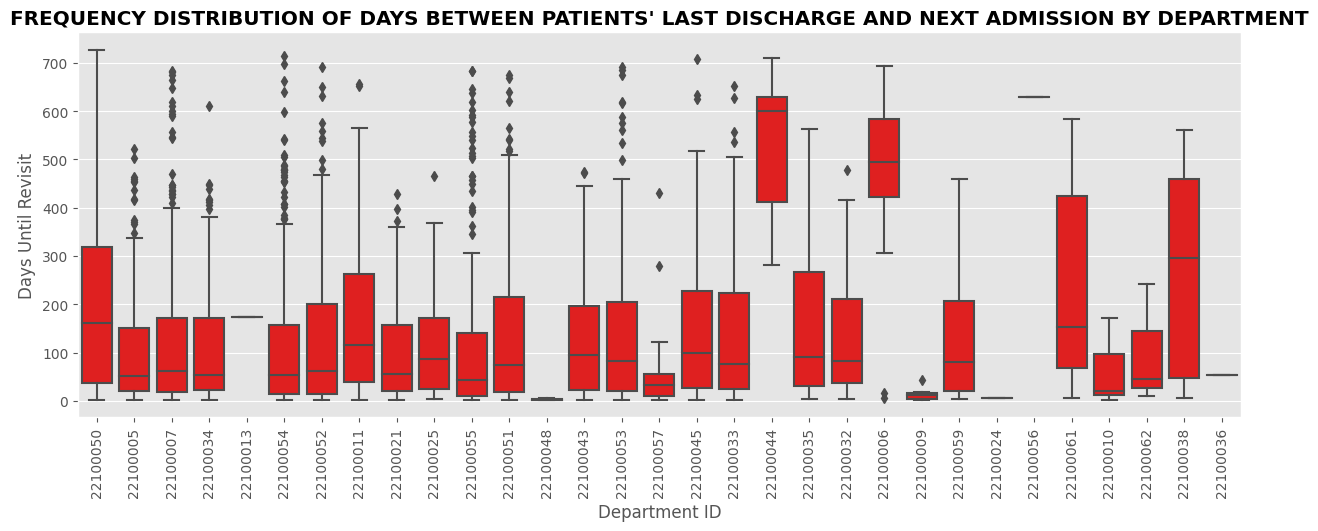

In [36]:
encounters=encounters.sort_values(['Master Patient ID','Patient Admission Datetime'])

encounters['Previous Date']=encounters.groupby('Master Patient ID')['Patient Discharge Datetime'].transform(lambda x:x.shift(1))

encounters_new=encounters[encounters['Previous Date'].notna()]
encounters_new=encounters_new[encounters_new['Previous Date']!=encounters_new['Patient Discharge Datetime']]

encounters_new['Days Until Revisit']=(encounters_new['Patient Admission Datetime']-encounters_new['Previous Date']).dt.total_seconds()/3600/24

encounters_new=encounters_new.query('`Days Until Revisit`>1')

plt.figure(figsize=(15,5))
ax=sns.boxplot(data=encounters_new,x='Department ID',y='Days Until Revisit',color='red')
#plt.yscale('log')
ax.set_xticklabels(encounters_new['Department ID'].unique(),rotation=90)
plt.title("FREQUENCY DISTRIBUTION OF DAYS BETWEEN PATIENTS' LAST DISCHARGE AND NEXT ADMISSION BY DEPARTMENT",fontweight='bold')
plt.show()